This notebook uses cifar dataset to analyse best practices when training CNNs including using techniques like transfer learning and learning rate scheduling. 

In [459]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [460]:
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os 
from tqdm import tqdm_notebook

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from clr import CyclicLR

In [461]:
path = "data/cifar10/"
use_gpu = torch.cuda.is_available()

In [462]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize([0.4914 ,  0.48216,  0.44653], [0.24703,  0.24349,  0.26159])
    ]),
    'val': transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4914 ,  0.48216,  0.44653], [0.24703,  0.24349,  0.26159])
    ]),
}

In [463]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [464]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

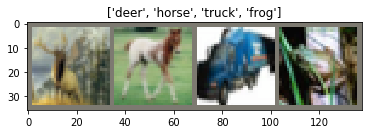

In [465]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914 ,  0.48216,  0.44653])
    std = np.array([0.24703,  0.24349,  0.26159])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs.narrow(0,0,4))

imshow(out, title=[class_names[x] for x in classes[0:4]])

In [466]:
inputs.size()

torch.Size([64, 3, 32, 32])

## Ol' Conv

In [467]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [468]:
#Plotting loss decrease over iterations
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [554]:
def train(epochs, model, criterion, optimizer, dataloaders, scheduler, plot_every=100):
    iters = 1
    plot_losses = []
    losses = []
    lrs = []
    plot_loss_total = 0 # Reset every plot_every
    
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                    
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()
                    #scheduler.batch_step()
                    plot_loss_total += loss.data[0]
                    loss.backward()
                    optimizer.step()
                    if iters % plot_every == 0:
                        lrs.append(scheduler.get_lr())
                        losses.append(loss.data[0])
                        plot_loss_avg = plot_loss_total / plot_every
                        plot_losses.append(plot_loss_avg)
                        plot_loss_total = 0
                    iters += 1
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase=='train':
                train_loss = epoch_loss; train_acc = epoch_acc
                continue
            print('Train Loss: {:.4f} Train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                train_loss, train_acc, epoch_loss, epoch_acc), end='\r', flush=True)
    showPlot(plot_losses)
    return losses, lrs

In [549]:
net = Net()
if use_gpu: net.cuda(); net

Preferred Optimization technique is SGD with momentum, cyclic learning rates and cosine annealing. [This](https://arxiv.org/abs/1705.08292) paper puts a strong case for moving away from adaptive optimization methods like Adam. Validating results were also found in practice with the above model. Below is a description of the most effective method. <br>
<b>Stochastic Gradient Descent</b> optimizer with [momentum](https://distill.pub/2017/momentum/) is used. Now, a natural difficulty is finding the most appropriate learning rate. <br>
An interesting solution to this is <b>[Cyclical Learning Rates](https://arxiv.org/abs/1506.01186)</b>. In simple words, it is about increasing the learning rate from an estimate of a minimum to an estimate of a maximum in a specified amount of iterations. The hope is that by recording the loss and the learning rate, the range of valid learning rates can be narrowed down. Furthermore, this narrowed down range of learning rates can be used in multiple cycles where the learning rate rise and falls. This is a great way to get out of local minimas. <br>
Another addition is <b>[cosine annealing](https://arxiv.org/pdf/1608.03983.pdf)</b> and warm restarts to squeeze a bit more out of the narrowed down learning rates. Cosine annealing will be reintroduced in a clever trick later. 

In [581]:
epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.007, momentum=0.9)
#optimizer = optim.RMSprop(net.parameters(), lr=0.01)
lrscheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dataloaders['train']), eta_min=0.0001)
#lrscheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.008, step_size=5*len(dataloaders['train']))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Train Loss: 0.6744 Train Acc: 0.7646 Val Loss: 0.9407 Val Acc: 0.6893


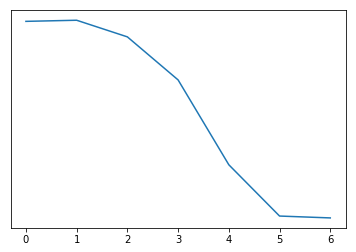

In [584]:
#782 iterations in 1 epoch
losses, lrs = train(epochs, net, criterion, optimizer, dataloaders, lrscheduler)

In [572]:
def plot_lr_loss(losses, lrs):
    plt.ylabel("loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(lrs, losses)
    plt.xscale('log')

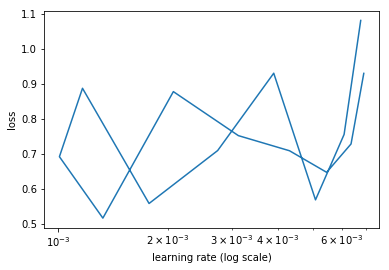

In [573]:
plot_lr_loss(losses, lrs)

In [585]:
def evaluate_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    correct = 0
    total = 0
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds.cpu().numpy() == labels.cpu().data.numpy()).sum()
        if i == len(dataloaders['val'])-1:
            print('Accuracy of the network on test images: %d %%' % (
                100 * correct / total))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return


Accuracy of the network on test images: 68 %


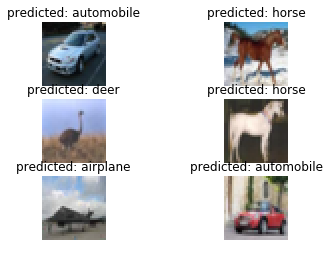

In [587]:
evaluate_model(net)